## Impoprting Libraires

In [1]:
import os
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import spectral
import tensorflow as tf
import keras
from keras.layers import (Conv3D,Conv2D, Dense, Dropout, Flatten, Input,
                          Reshape,MaxPooling2D)
from keras.losses import categorical_crossentropy
from keras.models import Model, Sequential
from keras.utils import np_utils
from sklearn.decomposition import (IncrementalPCA, KernelPCA, PCA, SparsePCA,
                                   TruncatedSVD)
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix)
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Activation, Lambda, multiply)
from tensorflow.keras.optimizers import Adam
from vit_keras import utils, vit
import spectral.io.envi as envi
from tensorflow.keras.optimizers import legacy
from operator import truediv

## Global Parameters

In [2]:
path='../../Datasets/HyperBlood/'

HSID = "E_1"    ## 'A_1.hdr', 'B_1.hdr', 'C_1.hdr', 'D_1.hdr', 'E_1.hdr', 'E_7.hdr', 
                ## 'E_21.hdr', 'F_1.hdr.hdr', 'F_1a.hdr', 'F_1s.hdr', 'F_2.hdr', 
                ## 'F_2k.hdr', 'F_7.hdr', 'F_21.hdr'
DLM = "PCA"     ## "PCA", "iPCA", "SPCA", "KPCA", "SVD"
WS = 9         ## 9, 11, 13, 15, 17, 19, 21, 23, 25
trRatio = 0.05 ##Percentage of Train Samples
vrRatio = 0.05 ##Percentage of Validation Samples
teRatio = 0.9 ##Percentage of Test Samples
k = 15
batch_size=256
epochs=20
adam = legacy.Adam(lr = 0.0001, decay = 1e-05)
# output_dir = os.path.join(f"results/test_ratio_{teRatio}")
output_dir = os.path.join(f"results/Epochs_{epochs}")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

C:\Users\hassa\miniconda3\envs\hsi\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [3]:
## Get HSI Data and Ground Truths
## Get HSI Data
def get_data(name,remove_bands=True,clean=True, path=path):
    """
    Input: name: name; remove_bands: if True, noisy bands are removed (leaving 113 bands)
    clean: if True, remove damaged line
    Output: data, wavelenghts as numpy arrays (float32)
    """
    name = convert_name(name)
    filename = "{}data/{}".format(path,name)
    hsimage = envi.open('{}.hdr'.format(filename),'{}.float'.format(filename))
    wavs = np.asarray(hsimage.bands.centers) 
    data = np.asarray(hsimage[:,:,:],dtype=np.float32)
    #removal of damaged sensor line
    if clean and name!='F_2k':
        data = np.delete(data,445,0)
    if not remove_bands:
        return data,wavs
    return data[:,:,get_good_indices(name)],wavs[get_good_indices(name)]

## Get Ground Truths
def get_anno(name,remove_uncertain_blood=True,clean=True, path=path):
    """
    Returns annotation (GT) for data files as 2D int numpy array
    Classes: 0 - background; 1 - blood; 2 - ketchup; 3 - artificial blood; 4 - beetroot juice
    5 - poster paint; 6 - tomato concentrate; 7 - acrtylic paint; 8 - uncertain blood;
    Input: name: name; clean: if True, remove damaged line; 
    remove_uncertain_blood: if True, removes class 8 
    Output: annotation as numpy 2D array 
    """
    name = convert_name(name)
    filename = "{}anno/{}".format(path,name)
    anno = np.load(filename+'.npz')['gt']
    #removal of damaged sensor line
    if clean and name!='F_2k':
        anno = np.delete(anno,445,0)
    #remove uncertain blood + technical classes
    if remove_uncertain_blood:
        anno[anno>7]=0
    else:
        anno[anno>8]=0
    return anno


def blood_loader(path, name):
    """
    returns data and annotation, removing classes that are not present in all images
    Input: path: data path; name: image name
    Output:img: data cube; gt: annotation with correct classes; 
    rgb_bands: three bands used for rgb visualisation
    ignored_labels: labels that should be ignored [0 for background] 
    label_values: class labels
    """
    img = np.asarray(get_data(name, path=path)[0], dtype='float32')
    gt = get_anno(name, path=path).astype('uint8')
    # remove beetroot juice (is only on frames images so in our
    # classification experiments we removed it from pictures)
    gt = np.where(gt == 4, 0, gt)
    # renumbering after removing beetroot juice
    for element in [5, 6, 7]:
        gt = np.where(gt == element, element - 1, gt)
    label_values = ["unclassified",
                    "blood",
                    "ketchup",
                    "artificial blood",
                    "poster paint",
                    "tomato concentrate",
                    "acrylic paint"]
    rgb_bands, ignored_labels = (47, 31, 15), [0]
    return img, gt, rgb_bands, ignored_labels, label_values

In [4]:
def convert_name(name):
    """
    Ensures that the name is in the filename format
    Parameters: name: name
    Output: cleaned name
    """
    name = name.replace('(','_')
    name = name.replace(')','')
    return name

def get_good_indices(name=None):
    """
    Input: name: name
    Output: numpy array of good indices         
    """
    name = convert_name(name)
    if name!='F_2k':
        indices = np.arange(128)
        indices = indices[5:-7]
    else:
        indices = np.arange(116)    
    indices=np.delete(indices,[43,44,45])
    return indices

In [5]:
## Load HSI Dataset
def LoadHSIData(method):
    ## List of HSI Dataasets
    HSI_list = ['A_1.hdr', 'B_1.hdr', 'C_1.hdr', 'D_1.hdr', 'E_1.hdr', 'E_7.hdr', 
                'E_21.hdr', 'F_1.hdr.hdr', 'F_1a.hdr', 'F_1s.hdr', 'F_2.hdr', 
                'F_2k.hdr', 'F_7.hdr', 'F_21.hdr']
    for i in range(len(HSI_list)):
        file_name = HSI_list[i].split('.')[0]
        data_path = os.path.join(os.getcwd(),'../../Datasets/HyperBlood/data'+str(file_name))
        # print(data_path)
        if os.path.exists(data_path) == False:
            # print("Data file from %s to %s" % (HSI_list[i], data_path))
            # #urllib.request.urlretrieve(url=HSI_url[i], filename=data_path)
            print(str(file_name)+" is Successfully Found")
        else:
            print(str(file_name) + " already exist")
    data_path = os.path.join(os.getcwd(),'../../Datasets/HyperBlood/data')
    data_path1 = os.path.join(os.getcwd(),'../../Datasets/HyperBlood/anno')
    if method == 'A_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'B_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'C_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'D_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')    
    elif method == 'E_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'E_7':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'E_21':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_1a':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_1s':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_2':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_2k':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')  
    elif method == 'F_7':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_21':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8') 
    # remove beetroot juice (is only on frames images so in our
    # classification experiments we removed it from pictures)
    # GT = np.where(GT == 4, 0, GT)
    # # renumbering after removing beetroot juice
    # for element in [5, 6, 7]:
    #     GT = np.where(GT == element, element - 1, GT)
    # rgb_bands, ignored_labels = (47, 31, 15), [0]
    return HSI, GT

In [6]:
## Dimension Reduction
def DLMethod(method, HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    if method == 'PCA': ## PCA
        pca = PCA(n_components = NC, whiten = True)
        RHSI = pca.fit_transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'iPCA': ## Incremental PCA
        n_batches = 256
        inc_pca = IncrementalPCA(n_components = NC)
        for X_batch in np.array_split(RHSI, n_batches):
            inc_pca.partial_fit(X_batch)
        X_ipca = inc_pca.transform(RHSI)
        RHSI = np.reshape(X_ipca, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'KPCA': ## Kernel PCA
        kpca = KernelPCA(kernel = "rbf", n_components = NC, gamma = None, 
                         fit_inverse_transform = True, random_state = 2019, 
                         n_jobs=1)
        kpca.fit(RHSI)
        RHSI = kpca.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'SPCA': ## Sparse PCA
        sparsepca = SparsePCA(n_components = NC, alpha=0.0001, random_state=2019, n_jobs=-1)
        sparsepca.fit(RHSI)
        RHSI = sparsepca.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'SVD': ## Singular Value Decomposition
        SVD_ = TruncatedSVD(n_components = NC,algorithm = 'randomized', 
                            random_state = 2019, n_iter=5)
        SVD_.fit(RHSI)
        RHSI = SVD_.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

In [7]:
## Padding and Spatial Patchs
def ZeroPad(HSI, margin = 2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI

## Compute the Patch to Prepare for Ground Truths
def Patch(HSI,height_index,width_index):
    height_slice = slice(height_index, height_index+WS)
    width_slice = slice(width_index, width_index+WS)
    patch = HSI[height_slice, width_slice, :]
    return patch
    
def ImageCubes(HSI, GT, WS = WS, removeZeroLabels = True):
    margin = int((WS - 1) / 2)
    zeroPaddedX = ZeroPad(HSI, margin = margin)
    # split patches
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WS, WS, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [8]:
## Classification Reports
def ClassificationReports(TeC, Te_Pred):
    Te_Pred = np.argmax(Te_Pred, axis=1)
    target_names = ["blood",
                    "ketchup",
                    "artificial blood",
                    "poster paint",
                    "tomato concentrate",
                    "acrylic paint"]
    classification = classification_report(np.argmax(TeC, axis=1), Te_Pred, target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), Te_Pred)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred)
    counter = confusion.shape[0]
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), Te_Pred)
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100, target_names

In [9]:
## Writing Classification Results
def CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa):
    classification = str(classification)
    confusion = str(confusion)
    with open(file_name, 'w') as CSV_file:
        
        CSV_file.write('{} Tr_Time'.format(Tr_Time))
        CSV_file.write('\n')
        CSV_file.write('{} Te_Time'.format(Te_Time))
        CSV_file.write('\n')
        CSV_file.write('{} DL_Time'.format(DL_Time))
        CSV_file.write('\n')
        CSV_file.write('{} Kappa accuracy (%)'.format(kappa))
        CSV_file.write('\n')
        CSV_file.write('{} Overall accuracy (%)'.format(oa))
        CSV_file.write('\n')
        CSV_file.write('{} Average accuracy (%)'.format(aa))
        CSV_file.write('\n')
        CSV_file.write('\n')
        CSV_file.write('{}'.format(classification))
        CSV_file.write('\n')
        CSV_file.write('{}'.format(confusion))
        return CSV_file
    
## Plot Ground Truths 
def GT_Plot(RDHSI, GT, model, WS):
    height, width = np.shape(GT)
    RDHSI = ZeroPad(RDHSI, WS//2) ## Zero Padding
    ## Calculate the predicted Ground Truths
    outputs = np.zeros((height, width))
    for AA in range(height):
        for BB in range(width):
            
            target = int(GT[AA,BB])
            if target == 0:
                continue
            else :
                image_patch = Patch(RDHSI,AA,BB)
                X_test_image = image_patch.reshape(1,image_patch.shape[0],
                                             image_patch.shape[1],
                                             image_patch.shape[2],
                                             1).astype('float32')
                prediction = (model.predict(X_test_image))
                prediction = np.argmax(prediction, axis=1)
                outputs[AA][BB] = prediction+1
    return outputs

In [10]:
## Plot and Save Confusion Matrix
def Conf_Mat(Te_Pred, TeC, target_names):
    plt.rcParams.update({'font.size': 12})
    Te_Pred = np.argmax(Te_Pred, axis=1)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred, labels=np.unique(np.argmax(TeC, axis=1)))
    cm_sum = np.sum(confusion, axis=1, keepdims=True)
    cm_perc = confusion / cm_sum.astype(float) * 100
    annot = np.empty_like(confusion).astype(str)
    nrows, ncols = confusion.shape
    for l in range(nrows):
        for m in range(ncols):
            c = confusion[l, m]
            p = cm_perc[l, m]
            if l == m:
                s = cm_sum[l]
                annot[l, m] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[l, m] = ''
            else:
                annot[l, m] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(confusion, index=np.unique(target_names), columns=np.unique(target_names))
    return cm, annot

In [11]:
HSI, GT = LoadHSIData(HSID)

print("# of Dimensions", k)          ## Dimensions
print("Shape of HSI", HSI.shape)
print("Shape of GT", GT.shape)
# UC = np.unique(label_values)
UC = np.unique(GT)
print("Name of Classes", UC)
Num_Classes = len(UC)
print("# of Classes", Num_Classes)

A_1 is Successfully Found
B_1 is Successfully Found
C_1 is Successfully Found
D_1 is Successfully Found
E_1 is Successfully Found
E_7 is Successfully Found
E_21 is Successfully Found
F_1 is Successfully Found
F_1a is Successfully Found
F_1s is Successfully Found
F_2 is Successfully Found
F_2k is Successfully Found
F_7 is Successfully Found
F_21 is Successfully Found
# of Dimensions 15
Shape of HSI (519, 696, 113)
Shape of GT (519, 696)
Name of Classes [0 1 2 3 5 6 7]
# of Classes 7


In [12]:
## Reduce the Dimensionality
start = time.time()
RDHSI = DLMethod(DLM, HSI, NC = k)
end = time.time()
DL_Time = end - start
print("DL_Time",DL_Time)

DL_Time 1.2845606803894043


In [13]:
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
print("Shape of HSI", CRDHSI.shape)
print("Shape of GT", CGT.shape)

Shape of HSI (33804, 9, 9, 15)
Shape of GT (33804,)


## GroundTruth Visulazation

## Band wise Visualization

In [14]:
def TrTeSplit(HSI, GT, trRatio, vrRatio, teRatio, randomState=345):
    # Split into train and test sets
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=teRatio,
                                        random_state=randomState, stratify=GT)
    # Calculate the validation ratio based on the updated test and train ratios
    totalTrRatio = trRatio + vrRatio
    new_vrRatio = vrRatio / totalTrRatio
    # Split train set into train and validation sets
    Tr, Va, TrC, VaC = train_test_split(Tr, TrC, test_size=new_vrRatio,
                                        random_state=randomState, stratify=TrC)

    return Tr, Va, Te, TrC, VaC, TeC

# trRatio = 0.11 
# vrRatio = 0.11 
# teRatio = 0.78 
Tr, Va, Te, TrC, VaC, TeC = TrTeSplit(CRDHSI, CGT, trRatio, vrRatio, teRatio)

# Reshape train, validation, and test sets
Tr = Tr.reshape(-1, WS, WS, k, 1)
print('Tr', Tr.shape)
TrC = np_utils.to_categorical(TrC)
print('TrC', TrC.shape)

Va = Va.reshape(-1, WS, WS, k, 1)
print('Va', Va.shape)
VaC = np_utils.to_categorical(VaC)
print('VaC', VaC.shape)

Te = Te.reshape(-1, WS, WS, k, 1)
print('Te', Te.shape)
TeC = np_utils.to_categorical(TeC)
print('TeC', TeC.shape)

Tr (1690, 9, 9, 15, 1)
TrC (1690, 7)
Va (1690, 9, 9, 15, 1)
VaC (1690, 7)
Te (30424, 9, 9, 15, 1)
TeC (30424, 7)


## 2D CNN

In [15]:
def CNN_2D(WS, k,Num_Classes):
    input_layer = Input((WS, WS, k))
    conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
    conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(conv_layer1)
    conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(conv_layer2)
    conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(conv_layer3)
    flatten_layer = Flatten()(conv_layer4)
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=Num_Classes, activation='softmax')(dense_layer2)
    model = Model(inputs=input_layer, outputs=output_layer, name='2D_CNN')
    return model

## 2D inception Net

In [16]:
def Inception_Net_2D(WS, k,Num_Classes):
    
    input_img = Input(shape=(WS, WS, k))
    ## Block 1
    layer_1 = Conv2D(30, (1, 1), padding = 'same', activation = 'relu')(input_img)
    layer_1 = Conv2D(20, (1, 1), padding = 'same', activation = 'relu')(layer_1)
    layer_1 = Conv2D(10, (3, 3), padding = 'same', activation = 'relu')(layer_1)
    ## Block 2
    layer_2 = Conv2D(40, (1, 1), padding = 'same', activation = 'relu')(input_img)
    layer_2 = Conv2D(20, (1, 1), padding = 'same', activation = 'relu')(layer_2)
    layer_2 = Conv2D(10, (5, 5), padding = 'same', activation = 'relu')(layer_2)
    ## Block 3
    layer_3 = MaxPooling2D((3, 3), strides = (1, 1), padding = 'same')(input_img)
    layer_3 = Conv2D(20, (1, 1), padding = 'same', activation = 'relu')(layer_3)
    layer_3 = Conv2D(10, (1, 1), padding = 'same', activation = 'relu')(layer_3)
    ## Concatination
    mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
    ## Convolution
    layer_4 = Conv2D(128, (1, 1), activation = 'relu')(mid_1)
    ## Classification Module
    flat_1 = Flatten()(layer_4)
    dense_1 = Dense(1200, activation = 'relu')(flat_1)
    dense_2 = Dense(600, activation = 'relu')(dense_1)
    dense_3 = Dense(150, activation = 'relu')(dense_2)
    output = Dense(Num_Classes, activation = 'softmax')(dense_3)
    ## Medel 
    model = Model([input_img], output, name='2D_Inception_Net')
    return model

## 3D inception Net

In [17]:
def Inception_Net_3D(WS, k,Num_Classes):
    input_img = Input(shape=(WS, WS, k, 1))
    ## Block 1
    layer_1 = Conv3D(30, (5, 5, 7), activation='relu')(input_img)
    layer_1 = Conv3D(20, (3, 3, 5), activation='relu')(layer_1)
    layer_1 = Conv3D(10, (3, 3, 3), activation='relu')(layer_1)
    ## Block 2
    layer_2 = Conv3D(40, (5, 5, 7), activation='relu')(input_img)
    layer_2 = Conv3D(20, (3, 3, 5), activation='relu')(layer_2)
    layer_2 = Conv3D(10, (3, 3, 3), activation='relu')(layer_2)
    ## Block 3
    layer_3 = Conv3D(60, (5, 5, 7), activation='relu')(input_img)
    layer_3 = Conv3D(30, (3, 3, 5), activation='relu')(layer_3)
    layer_3 = Conv3D(10, (3, 3, 3), activation='relu')(layer_3)
    ## Concatination
    mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
    ## Convolution
    layer_4 = Conv3D(128, (1, 1, 1), activation = 'relu')(mid_1)
    ## Classification Module
    flat_1 = Flatten()(layer_4)
    dense_1 = Dense(512, activation='relu')(flat_1)
    dense_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1)
    dense_2 = Dropout(0.4)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2)
    dense_3 = Dropout(0.4)(dense_3)
    output = Dense(Num_Classes, activation='softmax')(dense_3)
    model = Model([input_img], output, name='3D_Inception_Net')
    return model

## Hybrid Inception Net

In [18]:
def Hybrid_Inception_Net(WS, k,Num_Classes):
    input_img = Input(shape=(WS, WS, k, 1))
    ## Block 1
    layer_1 = Conv3D(30, (5, 5, 7), activation='relu')(input_img)
    layer_1 = Conv3D(20, (3, 3, 5), activation='relu')(layer_1)
    layer_1 = Conv3D(10, (3, 3, 3), activation='relu')(layer_1)
    layer_1_shape = layer_1.shape
    ## 2D Structure
    layer_1 = Reshape((layer_1_shape[1], layer_1_shape[2], layer_1_shape[3]*layer_1_shape[4]))(layer_1)
    layer_1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_1)
    layer_1 = Conv2D(filters = 16, kernel_size = (1, 1), activation = 'relu')(layer_1)
    layer_1 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu')(layer_1)
    layer_1 = Conv2D(filters = 64, kernel_size = (1, 1), activation = 'relu')(layer_1)
    ## Block 2
    layer_2 = Conv3D(40, (5, 5, 7), activation = 'relu')(input_img)
    layer_2 = Conv3D(20, (3, 3, 5), activation = 'relu')(layer_2)
    layer_2 = Conv3D(10, (3, 3, 3), activation = 'relu')(layer_2)
    ## 2D Structure
    layer_2_shape = layer_2.shape
    layer_2 = Reshape((layer_2_shape[1], layer_2_shape[2], layer_2_shape[3]*layer_2_shape[4]))(layer_2)
    layer_2 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_2)
    layer_2 = Conv2D(filters = 16, kernel_size = (1, 1), activation = 'relu')(layer_2)
    layer_2 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu')(layer_2)
    layer_2 = Conv2D(filters = 64, kernel_size = (1, 1), activation = 'relu')(layer_2)
    ## Block 3
    layer_3 = Conv3D(60, (5, 5, 7), activation='relu')(input_img)
    layer_3 = Conv3D(30, (3, 3, 5), activation='relu')(layer_3)
    layer_3 = Conv3D(10, (3, 3, 3), activation='relu')(layer_3)
    ## 2D Structure
    layer_3_shape = layer_3.shape
    layer_3 = Reshape((layer_3_shape[1], layer_3_shape[2], layer_3_shape[3]*layer_3_shape[4]))(layer_3)
    layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_3)
    layer_3 = Conv2D(filters = 16, kernel_size=(1, 1), activation = 'relu')(layer_3)
    layer_3 = Conv2D(filters = 32, kernel_size=(1, 1), activation = 'relu')(layer_3)
    layer_3 = Conv2D(filters = 64, kernel_size = (1, 1), activation = 'relu')(layer_3)
    ## Concatinate 
    mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
    ## Convolution
    layer_4 = Conv2D(filters = 128, kernel_size = (1, 1), activation = 'relu')(mid_1)
    ## Classification Model
    flat_1 = Flatten()(layer_4)
    dense_1 = Dense(512, activation='relu')(flat_1)
    dense_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1)
    dense_2 = Dropout(0.4)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2)
    dense_3 = Dropout(0.4)(dense_3)
    output = Dense(Num_Classes, activation='softmax')(dense_3)
    ## Medel 
    model = Model([input_img], output, name='Hybrid_Inception_Net')
    return model

## Hybrid CNN

In [19]:
def Hybrid_2D_3D_CNN(WS, k,Num_Classes):
    input_layer = Input((WS, WS, k, 1))
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
    ##conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 1), activation='relu')(conv_layer3)
    ## Conv3D with kernel_size=(3, 3, 1) can be used as well instead to reshape and Con2D.
    conv3d_shape = conv_layer3.shape
    conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
    conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
    flatten_layer = Flatten()(conv_layer4)
    dense_layer1 = Dense(units=256, activation = 'relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units = 128, activation = 'relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units = Num_Classes, activation = 'softmax')(dense_layer2)
    # Define the Model with Input and Output Layers
    model = Model(inputs = input_layer, outputs = output_layer, name='Hybrid_2D_3D')
    return model

## A Fast and Compact 3D CNN

In [20]:
def FC_3DCNN(WS, k,Num_Classes):
    input_layer = Input((WS, WS, k, 1))
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
    conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
    flatten_layer = Flatten()(conv_layer4)
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    output_layer = Dense(units = Num_Classes, activation='softmax')(dense_layer2)
    model = Model(inputs=input_layer, outputs=output_layer, name='FC_3D_CNN')
    return model

## Transformers Architecture

In [21]:
def get_positional_encoding(max_len, d_emb):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_emb)[np.newaxis, :]
    angles = pos / np.power(10000, 2 * i / d_emb)
    positional_encoding = np.zeros((max_len, d_emb))
    positional_encoding[:, ::2] = np.sin(angles[:, ::2])
    positional_encoding[:, 1::2] = np.cos(angles[:, 1::2])
    return positional_encoding[np.newaxis, ...]

class Transformer(tf.keras.layers.Layer):
    def __init__(self, num_heads, transformer_layer_depth, d_model, dff, dropout_rate=0.1, layernorm_eps=1e-6, **kwargs):
        super(Transformer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.transformer_layer_depth = transformer_layer_depth
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate
        self.layernorm_eps = layernorm_eps

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

    def call(self, inputs, training):
        x = inputs
        for i in range(self.transformer_layer_depth):
            # Multi-Head Attention
            attn_output = self.mha(x, x)
            attn_output = self.dropout1(attn_output, training=training)
            attn_output = self.layernorm1(x + attn_output)
            # Feed Forward Network
            ffn_output = self.dense1(attn_output)
            ffn_output = self.dense2(ffn_output)
            ffn_output = self.dropout2(ffn_output, training=training)
            ffn_output = self.layernorm2(attn_output + ffn_output)
            x = ffn_output
        return x

## Visulazation of Positional Encoding

## Custom Model

In [22]:
def Hybrid_ViT(WS, k, Num_Classes, num_transformer_layers=4, num_heads=8, dff=4*64, dropout_rate=0.1, layernorm_eps=1e-3):
    input_shape = (WS, WS, k)

    max_patch_size = min(input_shape[:3])
    patch_size = max_patch_size
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size) * (input_shape[2] // patch_size)
    embedding_dim = 64
    inputs = Input(shape=input_shape, name='inputs')
    x = tf.expand_dims(inputs, axis=1) # add this line
    # Create a patch embedding layer
    patch_embed = Conv3D(embedding_dim, kernel_size=(1, patch_size, patch_size), strides=(1, patch_size, patch_size), padding='valid', name='patch_embed')(x)

    cls_token = tf.Variable(tf.zeros((1, 1, 1, embedding_dim)), name='cls_token')
    # Add cls_token to patch embeddings
    patch_embed = tf.concat([tf.broadcast_to(cls_token, [tf.shape(patch_embed)[0], 1, 1, 1, embedding_dim]), patch_embed], axis=1)
    # Add positional encoding to patch embeddings
    pos_encoding = get_positional_encoding(num_patches+1, embedding_dim)

    patch_embed = patch_embed + pos_encoding
    # Create a Transformer encoder
    for i in range(num_transformer_layers):
        if i == 0:
            transformer_layer = Transformer(num_heads=num_heads, transformer_layer_depth=1, d_model=embedding_dim, dff=dff, name=f'transformer_layer_{i}')(patch_embed)
        else:
            transformer_layer = Transformer(num_heads=num_heads, transformer_layer_depth=1, d_model=embedding_dim, dff=dff, name=f'transformer_layer_{i}')(transformer_layer)

    # Use cross-attention between the patch embeddings and a separate set of learnable embeddings
    q = Dense(embedding_dim)(transformer_layer[:, 0, 0, 0])
    k = Dense(embedding_dim)(patch_embed[:, 1:, :, :, :])
    v = patch_embed[:, 1:, :, :, :]
    cross_attn_output = tf.matmul(q[:, tf.newaxis, :], k, transpose_b=True)
    cross_attn_output = cross_attn_output / tf.math.sqrt(tf.cast(embedding_dim, dtype=tf.float32))
    cross_attn_output = tf.nn.softmax(cross_attn_output, axis=-1)
    cross_attn_output = tf.matmul(cross_attn_output, v)
    # Concatenate cls_token and cross-attention output
    output_layer = tf.concat([transformer_layer[:, 0, 0, 0], cross_attn_output[:, 0, 0, 0]], axis=-1)
    # Add a few dense layers and a final softmax layer
    output_layer = Dense(dff, activation='relu')(output_layer)
    output_layer = Dense(dff, activation='relu')(output_layer)
    output_layer = Dense(Num_Classes, activation='softmax', name='output_layer')(output_layer)
    # Define the model
    model = Model(inputs=inputs, outputs=output_layer, name='Hybrid_ViT')
    return model

## Model Training and Evaluation

In [23]:
def train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC, adam, output_dir, HSID, teRatio, k, WS, DLM, RDHSI, GT,Num_Classes,batch_size,epochs):
    # Create the output directory if it doesn't exist
    output_dir = os.path.join(output_dir, "") + model_name.__name__

    os.makedirs(output_dir, exist_ok=True)

    # Calling Custom Model
    model = model_name(WS, k, Num_Classes)
    model.summary()

    # Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    # Training the model
    start = time.time()
    history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
    end = time.time()
    Tr_Time = end - start

    # Predicting with the model
    start = time.time()
    Te_Pred = model.predict(Te)
    end = time.time()
    Te_Time = end - start

     ##Classification Report
    classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, Te_Pred)
    print(classification)
#     # Writing Results in CSV File
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_Classification_Report_{model_name.__name__}.csv"
    CSV_file = CSVResults(os.path.join(output_dir, file_name), classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa)
  
    # #Confusion Matrix
    cm, annot = Conf_Mat(Te_Pred, TeC, target_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(cm, cmap= "Spectral", annot=annot, fmt='', ax=ax, linewidths=0.5)
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_Confusion_Matrix_{model_name.__name__}.png"
    plt.savefig(os.path.join(output_dir, file_name), dpi=500)
    
#     ## Ground Truths
    outputs = GT_Plot(RDHSI, GT, model, WS)
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_Ground_Truths_{model_name.__name__}.png"
    plt.figure(figsize=(10, 10))
    plt.imshow(outputs, cmap='nipy_spectral')
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, file_name), dpi=500)
    return history

In [24]:
# Define a list of model names
model_names = [CNN_2D, Inception_Net_2D,FC_3DCNN, Hybrid_2D_3D_CNN,Hybrid_ViT] # Add your model names here
# model_names = [Hybrid_ViT,Inception_Net_3D,Hybrid_Inception_Net ] # Add your model names here

# Loop over the model names and run train_and_evaluate_model() for each model
history_list = []
for model_name in model_names:
    history = train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC, adam, output_dir, HSID, teRatio, k, WS, DLM, RDHSI, GT, Num_Classes, batch_size, epochs)
    history_list.append(history)

Model: "2D_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 9, 15)]        0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 8)           1088      
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 256)               16640

C:\Users\hassa\miniconda3\envs\hsi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hassa\miniconda3\envs\hsi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hassa\miniconda3\envs\hsi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

             blood       0.00      0.00      0.00      2668
           ketchup       0.87      0.97      0.92      5259
  artificial blood       0.61      0.20      0.30      5774
      poster paint       0.82      0.99      0.90      5963
tomato concentrate       0.43      0.56      0.48      3541
     acrylic paint       0.65      0.97      0.78      7219

          accuracy                           0.70     30424
         macro avg       0.56      0.62      0.56     30424
      weighted avg       0.63      0.70      0.63     30424

Model: "2D_Inception_Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 9, 9, 15)]   0           []                               
                                                                          

Epoch 12/20
7/7 [==============================] - 1s 187ms/step - loss: 0.0195 - accuracy: 0.9994 - val_loss: 0.1131 - val_accuracy: 0.9604
Epoch 13/20
7/7 [==============================] - 1s 186ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.1154 - val_accuracy: 0.9592
Epoch 14/20
7/7 [==============================] - 1s 183ms/step - loss: 0.0114 - accuracy: 0.9994 - val_loss: 0.1014 - val_accuracy: 0.9627
Epoch 15/20
7/7 [==============================] - 1s 184ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.1051 - val_accuracy: 0.9639
Epoch 16/20
7/7 [==============================] - 1s 180ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.1037 - val_accuracy: 0.9621
Epoch 17/20
7/7 [==============================] - 1s 181ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.1038 - val_accuracy: 0.9639
Epoch 18/20
7/7 [==============================] - 1s 190ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1008 - val_accuracy: 0.9633
Epoch 19/20
7

Epoch 14/20
7/7 [==============================] - 1s 101ms/step - loss: 0.1891 - accuracy: 0.9438 - val_loss: 0.1935 - val_accuracy: 0.9450
Epoch 15/20
7/7 [==============================] - 1s 103ms/step - loss: 0.1727 - accuracy: 0.9391 - val_loss: 0.1765 - val_accuracy: 0.9414
Epoch 16/20
7/7 [==============================] - 1s 107ms/step - loss: 0.1704 - accuracy: 0.9432 - val_loss: 0.1845 - val_accuracy: 0.9314
Epoch 17/20
7/7 [==============================] - 1s 100ms/step - loss: 0.1573 - accuracy: 0.9503 - val_loss: 0.1661 - val_accuracy: 0.9402
Epoch 18/20
7/7 [==============================] - 1s 109ms/step - loss: 0.1474 - accuracy: 0.9533 - val_loss: 0.1601 - val_accuracy: 0.9509
Epoch 19/20
7/7 [==============================] - 1s 106ms/step - loss: 0.1378 - accuracy: 0.9562 - val_loss: 0.1550 - val_accuracy: 0.9574
Epoch 20/20
7/7 [==============================] - 1s 111ms/step - loss: 0.1357 - accuracy: 0.9580 - val_loss: 0.1537 - val_accuracy: 0.9521
Please report

7/7 [==============================] - 1s 107ms/step - loss: 0.3346 - accuracy: 0.8858 - val_loss: 0.2060 - val_accuracy: 0.9426
Epoch 14/20
7/7 [==============================] - 1s 125ms/step - loss: 0.2735 - accuracy: 0.9112 - val_loss: 0.1893 - val_accuracy: 0.9456
Epoch 15/20
7/7 [==============================] - 1s 107ms/step - loss: 0.2716 - accuracy: 0.9041 - val_loss: 0.1801 - val_accuracy: 0.9533
Epoch 16/20
7/7 [==============================] - 1s 101ms/step - loss: 0.2543 - accuracy: 0.9118 - val_loss: 0.1704 - val_accuracy: 0.9467
Epoch 17/20
7/7 [==============================] - 1s 101ms/step - loss: 0.2190 - accuracy: 0.9278 - val_loss: 0.1565 - val_accuracy: 0.9521
Epoch 18/20
7/7 [==============================] - 1s 107ms/step - loss: 0.2087 - accuracy: 0.9337 - val_loss: 0.1497 - val_accuracy: 0.9533
Epoch 19/20
7/7 [==============================] - 1s 102ms/step - loss: 0.2020 - accuracy: 0.9290 - val_loss: 0.1472 - val_accuracy: 0.9509
Epoch 20/20
7/7 [========

 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 1, 64)       0           ['dense_21[0][0]']               
 icingOpLambda)                                                                                   
                                                                                                  
 dense_22 (Dense)               (None, 1, 1, 2, 64)  4160        ['tf.__operators__.getitem_2[0][0
                                                                 ]']                              
                                                                                                  
 tf.linalg.matmul (TFOpLambda)  (None, 1, None, 1,   0           ['tf.__operators__.getitem_4[0][0
                                2)                               ]',                              
          

7/7 [==============================] - 1s 199ms/step - loss: 0.0147 - accuracy: 0.9988 - val_loss: 0.1036 - val_accuracy: 0.9657
Epoch 15/20
7/7 [==============================] - 1s 218ms/step - loss: 0.0117 - accuracy: 0.9994 - val_loss: 0.1083 - val_accuracy: 0.9651
Epoch 16/20
7/7 [==============================] - 1s 192ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.1094 - val_accuracy: 0.9651
Epoch 17/20
7/7 [==============================] - 1s 194ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.1067 - val_accuracy: 0.9680
Epoch 18/20
7/7 [==============================] - 1s 201ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.1100 - val_accuracy: 0.9651
Epoch 19/20
7/7 [==============================] - 1s 195ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.1172 - val_accuracy: 0.9651
Epoch 20/20
7/7 [==============================] - 1s 190ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1174 - val_accuracy: 0.9657
Please report this to the

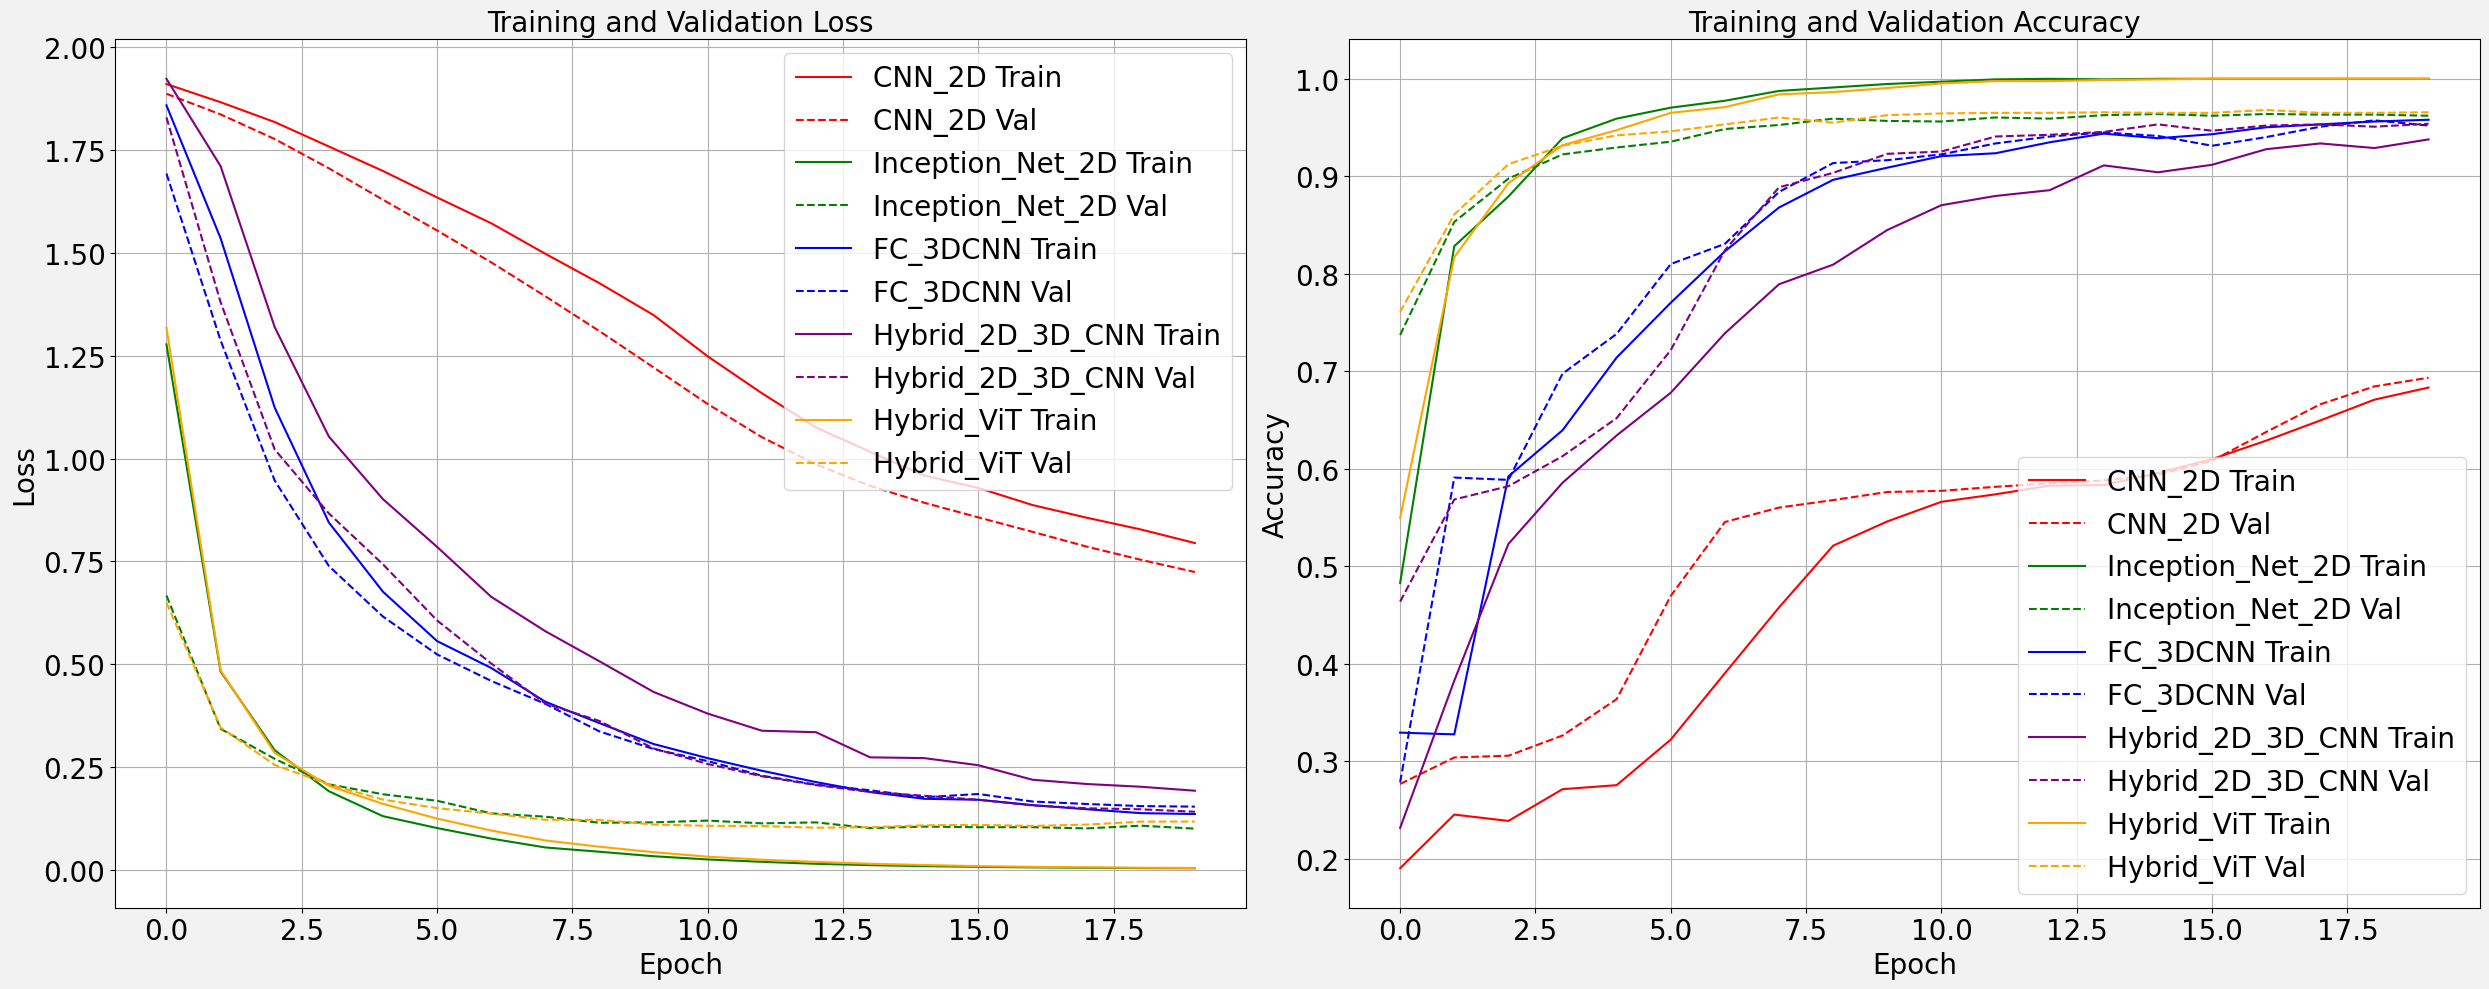

In [25]:
import matplotlib.font_manager as font_manager

# Define font size
font_size = 20

# Set font properties
font_prop = font_manager.FontProperties(size=font_size)

# Plot training and validation loss and accuracy for each model on one graph
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'gray', 'brown']

for i, history in enumerate(history_list):
    # Plot loss
    axs[0].plot(history.history['loss'], label=f'{model_names[i].__name__} Train', color=colors[i])
    axs[0].plot(history.history['val_loss'], label=f'{model_names[i].__name__} Val', color=colors[i], linestyle='--')

    # Plot accuracy
    axs[1].plot(history.history['accuracy'], label=f'{model_names[i].__name__} Train', color=colors[i])
    axs[1].plot(history.history['val_accuracy'], label=f'{model_names[i].__name__} Val', color=colors[i], linestyle='--')

# Add labels and legend with increased font size
axs[0].set_title('Training and Validation Loss', fontproperties=font_prop)
axs[0].set_xlabel('Epoch', fontproperties=font_prop)
axs[0].set_ylabel('Loss', fontproperties=font_prop)
axs[0].legend(prop=font_prop)

axs[1].set_title('Training and Validation Accuracy', fontproperties=font_prop)
axs[1].set_xlabel('Epoch', fontproperties=font_prop)
axs[1].set_ylabel('Accuracy', fontproperties=font_prop)
axs[1].legend(prop=font_prop)

# Increase tick label size
axs[0].tick_params(labelsize=font_size)
axs[1].tick_params(labelsize=font_size)

# Add grid lines and set background color
axs[0].grid(True)
axs[1].grid(True)
fig.patch.set_facecolor('#f2f2f2')
plt.tight_layout()

# Save the figure
file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_acc_loss_curve_all_models.png"
plt.savefig(os.path.join(output_dir, file_name), dpi=500)